In [ ]:
from typing import List, Optional
import sys
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
from PIL import Image, ImageDraw, ImageFont
from scipy.spatial import cKDTree
from scipy.stats import spearmanr

from main import dataloader, to_vect, Coordinates, calculate_asrs, classify_asrs


Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2022\trajectories_processed
Loading data from : C:\Users\HP\Desktop\Cours\Projet IA\data_2024\trajectories_processed


In [2]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 1.5


def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor


mushrooms_coords = session.mushroom_coords
mushrooms_coords = transform(mushrooms_coords, np.array([0, 0, 0]), ZOOM_FACTOR)[:,[0, 2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:, [0, 2]]
max_coord_x = int(mushrooms_coords[:, 0].max())
max_coord_z = int(mushrooms_coords[:, 1].max())

In [3]:
def draw_cross(draw: ImageDraw.Draw, coord: tuple[int, int], time: int):
    offset = 10
    topleft = (coord[0] - offset, coord[1] - offset)
    topright = (coord[0] + offset, coord[1] - offset)
    bottomleft = (coord[0] - offset, coord[1] + offset)
    bottomright = (coord[0] + offset, coord[1] + offset)
    draw.line(topleft + bottomright, fill=(0, 0, 255), width=4)
    draw.line(topright + bottomleft, fill=(0, 0, 255), width=4)
    font = ImageFont.load_default(size=20)
    draw.text((coord[0] + 30, coord[1]), anchor="mm", fill="blue",
                  text=f"{time}mn", font=font, align="center")


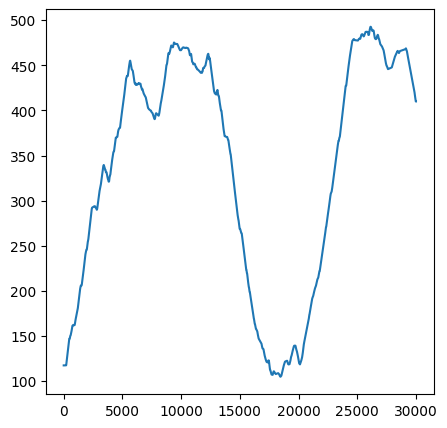

In [4]:
plt.figure(figsize=(5, 5))
plt.plot(player_coords[:,0])
plt.show()

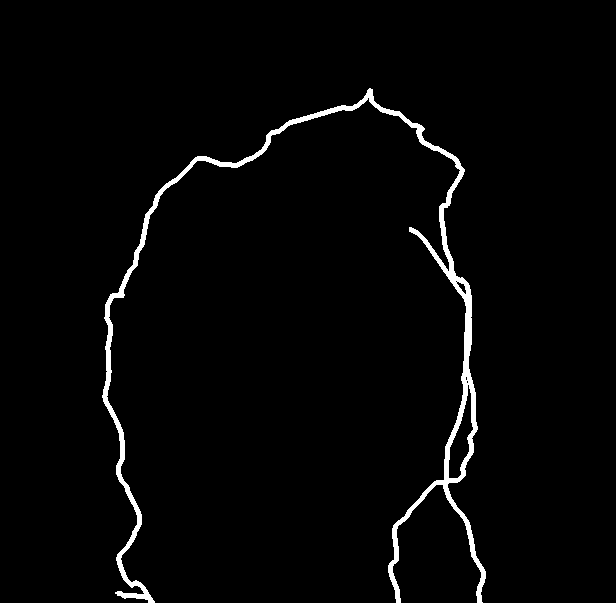

In [5]:
with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    draw.line([tuple(p) for p in player_coords.astype(int)], fill=1, width=5)
    display.display(im)
    player_trajectory = np.array(im)

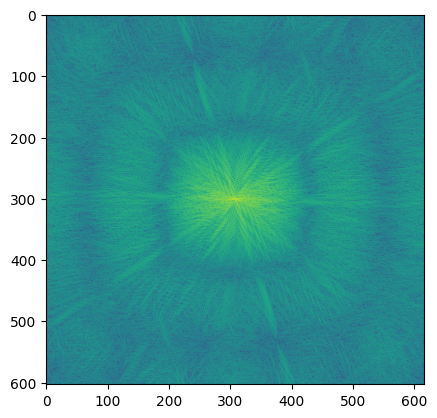

In [6]:
fft_transform = np.fft.fftshift(np.fft.fft2(player_trajectory))
fft_transform = np.log(abs(fft_transform))
# with Image.fromarray(fft_transform.astype(np.int8), mode="L") as im:
#     display.display(im)
plt.imshow(fft_transform)
